In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [22]:
def prune(random, refractory):
    spikes = []
    a = random.copy()
    while len(a) > 1:
        spikes.append(a[0])
        a = a[a - a[0] > refractory]
    return np.array(spikes)


def generate_neurons(post, p):
    idxs = np.random.permutation(np.arange(p['n_stim']).astype(int))
    p['n_response'] = int(p['n_stim'] * p['stim_hit_chance'])
    idxs_response = idxs[:p['n_response']]

    spikes = np.sort(np.concatenate([
        stim_times[idxs_response] + p['stim_latency'],
        np.sort(np.random.uniform(0, p['stop_time'], p['pre_rate'] * p['stop_time']))
    ]))
    spikes = prune(spikes, p['refractory'])
    n_spikes = len(spikes)
    p['n_post'] = int(n_spikes * p['pre_hit_chance'])
    if post:
        post_idxs = np.random.permutation(np.arange(n_spikes).astype(int))[:p['n_post']]

        response_spikes = np.sort(np.concatenate([
            spikes[post_idxs] + p['latency'],
            np.random.uniform(0, p['stop_time'], int(p['post_rate'] * p['stop_time']))
        ]))
        response_spikes = prune(response_spikes, p['refractory'])
    
        return spikes, response_spikes
    else:
        return spikes

In [64]:
def calculate_response(stim_times, source, target, winsize, latency):
    src = np.searchsorted
    result = {
        'stim_response': (
            # stim response
            src(source, stim_times, 'left') <
            src(source, stim_times + winsize, 'right')),
        'syn_response': (
            # stim synaptic response
            src(target, stim_times + latency, 'left') <
            src(target, stim_times + latency + winsize, 'right'))
    }
    return result


def calculate_hit_chance(stim_times, target, winsize):
    src = np.searchsorted
    z0 = (# stim response
        src(target, stim_times, 'left') <
        src(target, stim_times + winsize, 'right'))
    z0 = z0 == 0
    z1 = z0 == False
    return sum(z1) / len(z1)


def wald(stim_times, source, target, winsize, latency):
    """The IV estimator used in the paper"""
    responses = calculate_response(
        stim_times, source, target, winsize, latency)
    z_s1_x0 = responses['stim_response'] == 0
    z_s1_x1 = z_s1_x0 == False
    
    y_s1_x0 = responses['syn_response'][z_s1_x0]
    y_s1_x1 = responses['syn_response'][z_s1_x1]
    
    y_s1 = (y_s1_x1.mean() - y_s1_x0.mean()) / (z_s1_x1.mean() - z_s1_x0.mean())
    
    return y_s1

In [65]:
results = []

for h in np.arange(.1, 1.1, .1):
    params = {
        'stop_time': 2000, # seconds
        'refractory': 4e-3, # 4 ms
        'latency': 6e-3, # C response delay
        'pre_hit_chance': .8, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_latency': 5e-4, # .5 ms
        'stim_rate': 30,
        'stim_hit_chance': h, # fraction of spikes that are driven by the stimulation
        'stim_refractory': .05, # refractory time of stimulation
        'winsize': 1e-3
    }

    stim_times = np.sort(np.random.uniform(
        0, params['stop_time'], params['stim_rate'] * params['stop_time']))
    stim_times = prune(stim_times, params['stim_refractory'])
    params.update({
        'n_stim': len(stim_times)
    })
    
    A_spikes, C_spikes = generate_neurons(True, params)

    B_spikes = generate_neurons(False, params)
    
    assert all(np.diff(A_spikes) >= params['refractory'])
    assert all(np.diff(B_spikes) >= params['refractory'])
    assert all(np.diff(C_spikes) >= params['refractory'])
    
    beta_AC = wald(stim_times, A_spikes, C_spikes, params['winsize'], params['latency'])
    beta_BC = wald(stim_times, B_spikes, C_spikes, params['winsize'], params['latency'])
    
    params.update({
        'calculated_stim_hit_chance': calculate_hit_chance(stim_times, A_spikes, params['stim_latency'] * 1.5),
        'calculated_pre_hit_chance': calculate_hit_chance(A_spikes, C_spikes, params['latency'] * 1.5),
        'E_pre_response_rate': params['n_response'] / params['stop_time'],
        'E_post_response_rate': params['n_post'] / params['stop_time'],
        'E_pre_rate': params['n_response'] / params['stop_time'] + params['pre_rate'],
        'E_post_rate': params['n_post'] / params['stop_time'] + params['post_rate'],
        'A_rate': len(A_spikes) / params['stop_time'], 
        'B_rate': len(B_spikes) / params['stop_time'], 
        'C_rate': len(C_spikes) / params['stop_time'],
        'relative_induced_rate': (len(C_spikes) / params['stop_time']) / (params['n_post'] / params['stop_time']) - 1,
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    })
    results.append(params)
    
    


In [66]:
results = pd.DataFrame(results)
results

,A_rate,B_rate,C_rate,E_post_rate,E_post_response_rate,E_pre_rate,E_pre_response_rate,beta_AC,beta_BC,calculated_pre_hit_chance,...,pre_hit_chance,pre_rate,refractory,relative_induced_rate,stim_hit_chance,stim_latency,stim_rate,stim_refractory,stop_time,winsize
0,6.0520,6.0640,9.5760,9.8510,4.8510,6.1985,1.1985,-0.977566,0.003219,0.810393,...,0.8,5,0.004,0.974026,0.1,0.0005,30,0.05,2000,0.001
1,7.2005,7.2075,10.4410,10.7660,5.7660,7.3955,2.3955,-1.309728,-0.003600,0.812166,...,0.8,5,0.004,0.810787,0.2,0.0005,30,0.05,2000,0.001
2,8.3820,8.3590,11.3930,11.6870,6.6870,8.6120,3.6120,-1.943405,0.017060,0.811739,...,0.8,5,0.004,0.703754,0.3,0.0005,30,0.05,2000,0.001
3,9.5060,9.5200,12.2245,12.6160,7.6160,9.7905,4.7905,-3.740291,-0.030851,0.810961,...,0.8,5,0.004,0.605108,0.4,0.0005,30,0.05,2000,0.001
4,10.7045,10.7115,13.1215,13.5690,8.5690,11.0305,6.0305,-77.374125,0.323222,0.810454,...,0.8,5,0.004,0.531276,0.5,0.0005,30,0.05,2000,0.001
5,11.8080,11.8010,13.9885,14.4405,9.4405,12.2045,7.2045,4.311250,0.016764,0.810510,...,0.8,5,0.004,0.481754,0.6,0.0005,30,0.05,2000,0.001
6,12.9525,12.9390,14.8505,15.3510,10.3510,13.3690,8.3690,2.070121,0.010692,0.811426,...,0.8,5,0.004,0.434692,0.7,0.0005,30,0.05,2000,0.001
7,14.1180,14.1260,15.7845,16.3005,11.3005,14.6000,9.6000,1.362810,0.015117,0.811482,...,0.8,5,0.004,0.396797,0.8,0.0005,30,0.05,2000,0.001
8,15.2910,15.2815,16.6945,17.2250,12.2250,15.7965,10.7965,1.016698,0.016390,0.810640,...,0.8,5,0.004,0.365603,0.9,0.0005,30,0.05,2000,0.001
9,16.4785,16.4645,17.6015,18.1715,13.1715,17.0430,12.0430,0.815014,-0.018544,0.811906,...,0.8,5,0.004,0.336332,1.0,0.0005,30,0.05,2000,0.001


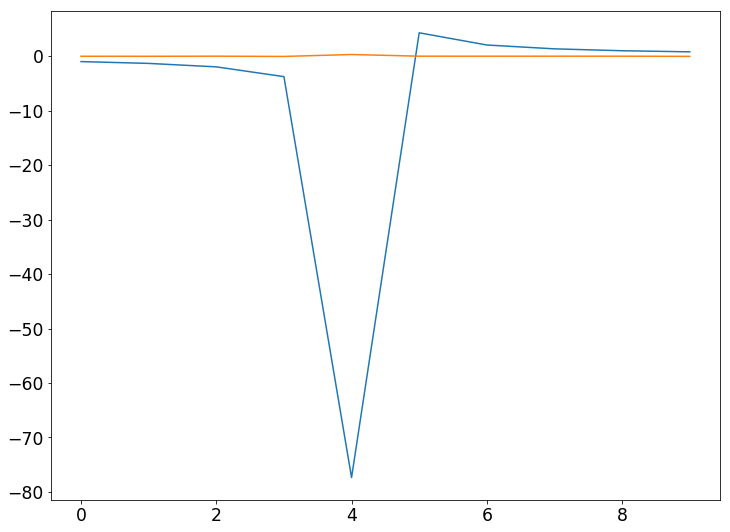

In [68]:
plt.plot(results['beta_AC'])
plt.plot(results['beta_BC'])